In [2]:
import numpy as np
import matplotlib.pyplot as plt
import kwant
import scipy.sparse.linalg as sla
import scipy.sparse as sp
from scipy.constants import hbar, e, m_e, h
from types import SimpleNamespace
import tinyarray
import time
import sys
import os

# Simulating graphene quantum dots

I will start by making graphene quantum dots with different shapes. The most interesting shapes for our sake are:

1. **Circular**
2. **Hexagonal**
3. **Triangular**
4. **Nanoribbons**

Nanoribbons do not really classify as quantum dots, but they have nice topological properties that could be useful.

The functions `create_graphene_hexagonal_system`, `create_graphene_tiangular_system` and `create_graphene_circular_system` will create graphene quantum dots of the specified shapes, the first two functions have a `start` parameter which is a starting angle and `type_` which specifies the edge types (zigzag or armchair), with the default being armchair. `param` parameter is an object where the miscellaneous parameters of the model are stored, such as (nnn) interaction coefficient `t_prime` and the magnetic field strength (normalized with the flux quanta $\hbar/e$) `B`.

In [528]:
# define pauli matrices
sigma_0 = tinyarray.array([[1, 0], [0, 1]])
sigma_x = tinyarray.array([[0, 1], [1, 0]])
sigma_y = tinyarray.array([[0, -1j], [1j, 0]])
sigma_z = tinyarray.array([[1, 0], [0, -1]])

lat = kwant.lattice.honeycomb(a = 1.0, norbs=2)
a_lat, b_lat = lat.sublattices

nnn_hoppings_a = (((-1, 0), a_lat, a_lat), ((0, 1), a_lat, a_lat), ((1, -1), a_lat, a_lat))
nnn_hoppings_b = (((1, 0), b_lat, b_lat), ((0, -1), b_lat, b_lat), ((-1, 1), b_lat, b_lat))
nnn_hoppings_all = nnn_hoppings_a + nnn_hoppings_b
lat_neighbors_2 = [kwant.builder.HoppingKind(*hop) for hop in nnn_hoppings_all]

def onstie(site, param):
    x, y = site.pos
    return param.m*sigma_0 if site.family == a_lat else -param.m*sigma_0
def nn_hopping(site1, site2, param):
    x1, y1 = site1.pos
    x2, y2 = site2.pos
    return np.exp(-1j*param.B/2*(x2 - x1)*(y1 + y2))*sigma_0
def nnn_hopping(site1, site2, param):
    x1, y1 = site1.pos
    x2, y2 = site2.pos
    return 1j*param.t_prime*np.exp(-1j*param.B/2*(x2 - x1)*(y1 + y2))*sigma_z


def atan(y, x):
    ans = np.arctan2(y, x)
    if type ( x + 0.0) == type(y+0.0) and type(x+0.0) in [float, np.float64, np.float128, np.float_]:

        if ans < 0: return 2*np.pi + ans
        else: return ans

    elif type(x) == type(y) and type(x) == type(np.array([])) :
        ans[ans < 0] += 2*np.pi
        return ans

    else: raise TypeError("atan is getting neither floats nor arrays")

# define graphene lattices
def create_graphene_hexagonal_system(r, start = 0, a = 1.0, norb = 2, type_ = 'zigzag'):
    lat = kwant.lattice.honeycomb(a = a, norbs=norb)
    a_lat, b_lat = lat.sublattices

    # returns a boolean function which tests whether the vector is inside the regular polygon
    def Regular_Polygon(r, n = 6, start = 0):
        if n < 3: raise RuntimeError("n >= 3")
        # start specifies the first radius starting angle
        def is_inside(point):
            x, y = point
            # y-=1
            if type_ == 'zigzag':y -=1
            else: y += 1
            angle = atan(y, x) - start
            angle %= (2*np.pi/n)
            alpha = (n - 2)/2/n*np.pi
            return np.sqrt(x*x + y*y) < np.sin(alpha)/np.sin(alpha + angle)*r
        return is_inside
    
    # create system
    sys = kwant.Builder()
    sys[lat.shape(Regular_Polygon(r, start=start), (0, 0))] = onstie # onsite energies are set to 0
    sys[lat.neighbors(n=1)] = nn_hopping

    # Choose a specific site

    sites = list(sys.sites())
    # Count the number of connections (hopping terms) for the site
    # make sure that no lattice point is connected to more than one site
    for s in sites:
        num_connections = sum(1 for _ in sys.neighbors(s))
        if num_connections == 1: del sys[s]

    # sys[lat.neighbors(n=2)] = nnn_hopping
    sys[lat_neighbors_2] = nnn_hopping

    return sys

def create_graphene_tiangular_system(r, start = 0, a = 1.0, norb = 2, type_ = 'zigzag'):
    lat = kwant.lattice.honeycomb(a = a, norbs=norb)
    a_lat, b_lat = lat.sublattices
    # returns a boolean function which tests whether the vector is inside the regular polygon
    def Regular_Polygon(r, n = 3, start = 0):
        if n < 3: raise RuntimeError("n >= 3")
        # start specifies the first radius starting angle
        def is_inside(point):
            x, y = point
            # y-=1
            if type_ == 'zigzag':y -=1
            angle = atan(y, x) - start
            angle %= (2*np.pi/n)
            alpha = (n - 2)/2/n*np.pi
            return np.sqrt(x*x + y*y) < np.sin(alpha)/np.sin(alpha + angle)*r
        return is_inside

    # create system
    sys = kwant.Builder()
    sys[lat.shape(Regular_Polygon(r, start=start), (0, 0))] = onstie # onsite energies are set to 0
    sys[lat.neighbors(n=1)] = nn_hopping

    # Choose a specific site
    sites = list(sys.sites())
    # Count the number of connections (hopping terms) for the site
    # make sure that no lattice point is connected to more than one site
    for __ in range(2):
        sites = list(sys.sites())
        for s in sites:
            num_connections = sum(1 for _ in sys.neighbors(s))
            if num_connections == 1 or num_connections == 0: del sys[s]
    
    # sys[lat.neighbors(n=2)] = nnn_hopping
    sys[lat_neighbors_2] = nnn_hopping
    
    return sys

def create_graphene_circular_system(r, a=1.0, norb=2):
    lat = kwant.lattice.honeycomb(a=a, norbs=norb)
    a_lat, b_lat = lat.sublattices
    
    sys = kwant.Builder()
    sys[lat.shape(lambda pos: np.linalg.norm(np.array([*pos])) < r, (0, 0))] = onstie
    sys[lat.neighbors(n=1)] = nn_hopping

    for __ in range(3):
        sites = list(sys.sites())
        for s in sites:
            num_connections = sum(1 for _ in sys.neighbors(s))
            if num_connections == 1 or num_connections == 0: del sys[s]

    # sys[lat.neighbors(n=2)] = nnn_hopping
    sys[lat_neighbors_2] = nnn_hopping

    return sys

def create_graphene_nanoribbon(width, length, a=1.0, norb=1):
    lat = kwant.lattice.honeycomb(a=a, norbs=norb)
    a_lat, b_lat = lat.sublattices

    sys = kwant.Builder()
    sys[lat.shape(lambda pos: abs(pos[1]) < width and abs(pos[0])<length, (0, 0))] = onstie
    sys[lat.neighbors(n=1)] = nn_hopping

    for __ in range(3):
        sites = list(sys.sites())
        for s in sites:
            num_connections = sum(1 for _ in sys.neighbors(s))
            if num_connections == 1 or num_connections == 0: del sys[s]

    sys[lat_neighbors_2] = nnn_hopping
    # sys[lat.neighbors(n=2)] = nnn_hopping
    # attach leads
    sym = kwant.TranslationalSymmetry((-a, 0))
    lead = kwant.Builder(sym)
    lead[lat.shape(lambda pos: abs(pos[1]) < width, (0, 0))] = onstie
    lead[lat.neighbors(n=1)] = nn_hopping
    # lead[lat.neighbors(n=2)] = nnn_hopping
    lead[lat_neighbors_2] = nnn_hopping
    sys.attach_lead(lead)
    sys.attach_lead(lead.reversed())
    return sys

The Hamiltonian class is meant to ease dealing with the hamiltonians, getting eigenvalues, and plotting them, `.sol()` should be called to get the eigenvalues and/or vectors

In [529]:
class Hamiltonian:
    def __init__(self, h, norb=1, N=None):
        self.h = h
        if N is None: self.N = h.shape[0]
        else: self.N = N
        self.n_sites = h.shape[0]//norb
        self.sol = None
        self.energies = None
        self.eigenstates = None
        self.norb=norb
    
    def solve(self, k=None, return_eigenvectors=True):
        
        if k is None: k = self.N-2*self.norb
        self.k = k
        self._returned_eigenvectors = return_eigenvectors
        if return_eigenvectors is False:
            self.sol =  [sla.eigsh(self.h, k=k, which='SM', return_eigenvectors=return_eigenvectors)]
        else:
            self.sol =  sla.eigsh(self.h, k=k, which='SM', return_eigenvectors=return_eigenvectors)
    
    def get_eigenvalues(self):
        if self.sol is None: self.solve(return_eigenvectors=False)
        self.eigenenergies_preorb = np.sort(self.sol[0])
        if self.norb > 1:
            self.eigenenergies = np.zeros((self.k//self.norb, self.norb))
            for orb in range(self.norb):
                self.eigenenergies[:, orb] = self.eigenenergies_preorb[orb::self.norb]
        else: self.eigenenergies = self.eigenenergies_preorb
        return self.eigenenergies
    
    def get_eigenstates(self):
        if self._returned_eigenvectors is False: self.solve(return_eigenvectors=True)
        self.eigenstates_preorb = (self.sol[1].T)[np.argsort(self.sol[0])]
        if self.norb > 1:    
            self.eigenstates = np.zeros((self.k, self.n_sites, self.norb), dtype=complex)
            for orb in range(self.norb):
                self.eigenstates[:, :, orb] = self.eigenstates_preorb[:, orb::self.norb]
        else:
            self.eigenstates = self.eigenstates_preorb
        return self.eigenstates
    
    def get_eigenstate(self, i, orb=None):
        if self.eigenstates is None: self.get_eigenstates()
        if orb is None: return self.eigenstates[i]
        elif orb > self.norb: raise ValueError("orbital index out of range")
        return self.eigenstates[i, :, orb-1]
    
    def zero_energy(self):
        if self.eigenenergies is None: self.get_eigenvalues()
        return np.where(np.allclose(np.abs(self.eigenenergies), 0, rtol=1e-2))[0]
    
    def plot_state(self, system, i):
        if self.eigenstates is None: self.get_eigenstates()
        kwant.plotter.map(sys=system, value=self.eigenstates[i], oversampling=10, cmap='inferno', show=True, dpi=400)
        plt.show()


## Triangular Isolated dots

In [530]:
triangular_predot = create_graphene_tiangular_system(10, np.pi/2, 1.0, 2, 'zigzag')

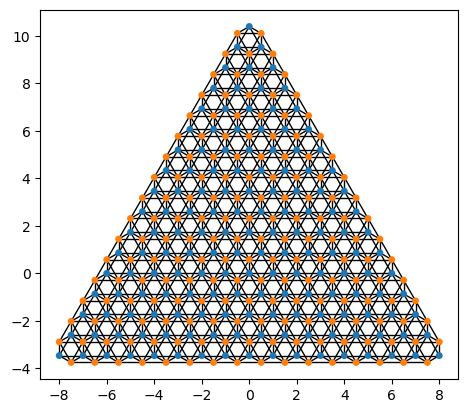

In [531]:
kwant.plot(triangular_predot)
plt.show()

In [545]:
triangular_dot = triangular_predot.finalized()
h = triangular_dot.hamiltonian_submatrix(params=dict(param = SimpleNamespace(B=0.0, t_prime=0.05, m=0.0)), sparse=True)
N = h.shape[0]

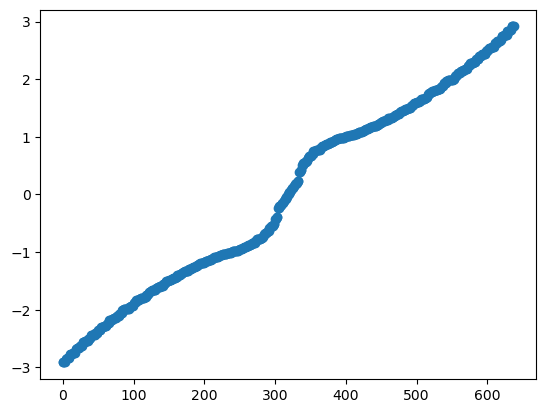

In [546]:
hamiltonian = Hamiltonian(h, norb=2)
hamiltonian.solve(return_eigenvectors=True)
energies = hamiltonian.get_eigenvalues()
plt.scatter(range(N-4), energies)
plt.show()

In [547]:
hamiltonian.get_eigenstate(44, orb=1).shape

(321,)

/tmp/ipykernel_161612/1996123640.py:51: DeprecationWarning:

Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(cond).nonzero()` if the old behavior was intended. If the context of this warning is of the form `arr[nonzero(cond)]`, just use `arr[cond]`.



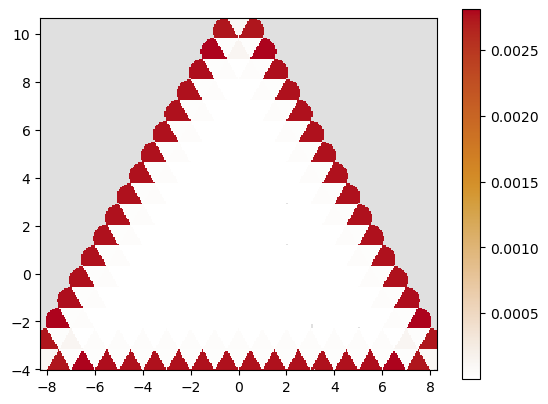

In [548]:
state = np.zeros_like(hamiltonian.get_eigenstate(44, orb=2))
for ind in hamiltonian.zero_energy():
    state += hamiltonian.get_eigenstate(ind, orb=1)
if not np.allclose(state, 0): state /=np.sqrt(len(hamiltonian.zero_energy()))
if np.allclose(state, 0): state = hamiltonian.get_eigenstate(320, orb=1)

kwant.plotter.map(triangular_dot, np.abs(state)**2, oversampling=10)
plt.show()

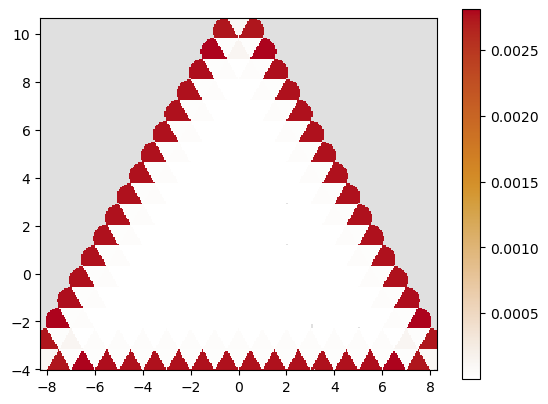

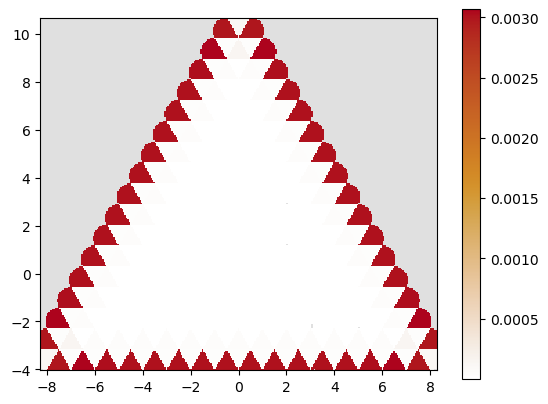

In [549]:
state1 = hamiltonian.get_eigenstate(320, orb=1)
state2 = hamiltonian.get_eigenstate(321, orb=2)
kwant.plotter.map(triangular_dot, np.abs(state1)**2, oversampling=10)
plt.show()
kwant.plotter.map(triangular_dot, np.abs(state2)**2, oversampling=10)
plt.show()

In [550]:
current_plot_state = np.zeros([len(state1)+ len(state2)])*0.0j
current_plot_state[::2] = state1
current_plot_state[1::2] = state2

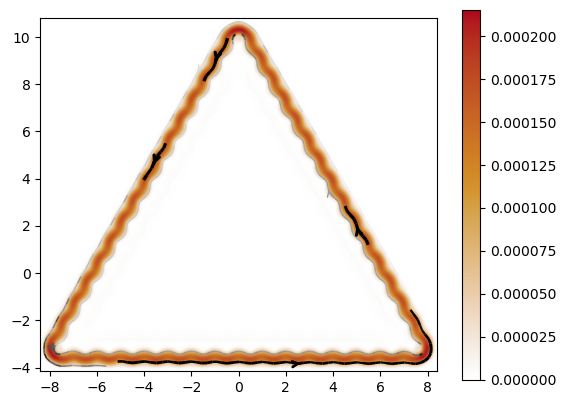

array([ 9.89722558e-05, -9.89722558e-05,  4.94000285e-07, ...,
       -2.44082699e-08, -2.48106307e-05, -2.45618296e-05])

In [553]:
# calculate the current
def calculate_current(sys, state, param, plot=False):
    current = kwant.operator.Current(sys, sigma_0)
    i = current(state, params=dict(param=param))
    if plot:
        kwant.plotter.current(sys, i)
        plt.show()
    return i

calculate_current(triangular_dot, current_plot_state, SimpleNamespace(B=0.0, t_prime=0.05), plot=True)

## Nanoribbons

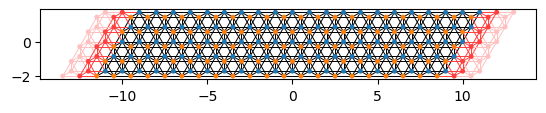

In [506]:
# create a nanoribbon
ribbon = create_graphene_nanoribbon(2.2, 10, 1.0, 2)
kwant.plot(ribbon)
plt.show()
ribbon = ribbon.finalized()

In [507]:
len(ribbon.sites)

210

In [514]:
# ribbon_parameters = SimpleNamespace(B=0., t_prime=0.1, m=0.09742275)
ribbon_parameters = SimpleNamespace(B=0., t_prime=0.04, m=0.0)

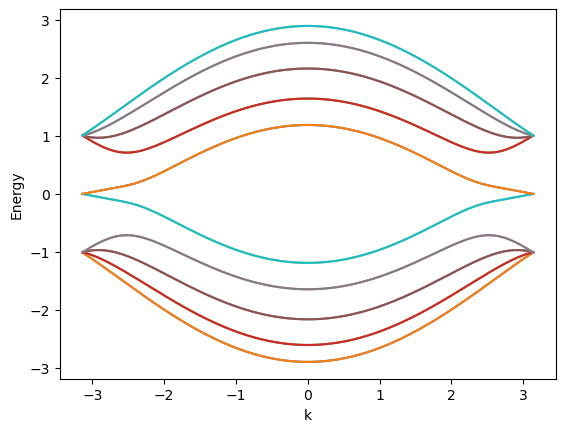

In [515]:
kwant.plotter.bands(ribbon.leads[0], params=dict(param=ribbon_parameters), show=True, momenta=np.linspace(-np.pi, np.pi, 256))
plt.show()

In [516]:
state_rib = kwant.wave_function(ribbon, energy=0.0, params=dict(param=ribbon_parameters))
state_rib = state_rib(0)
state_rib.shape

(2, 420)

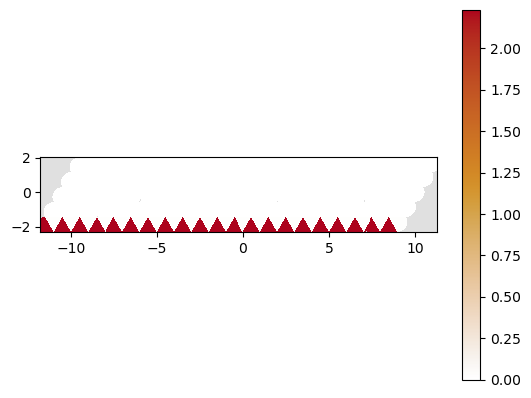

In [521]:
kwant.plotter.map(ribbon, np.abs(state_rib[0][1::2])**2, oversampling=10)
plt.show()

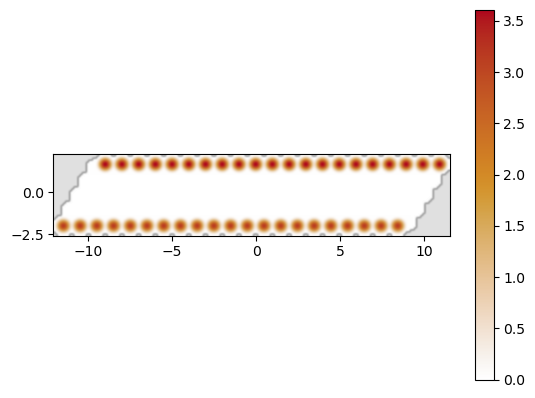

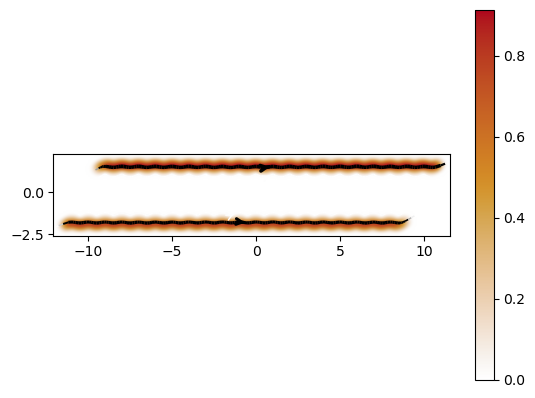

In [519]:
density_rib_op = kwant.operator.Density(ribbon)
current_rib_op = kwant.operator.Current(ribbon)


density_rib = density_rib_op(state_rib[1], params=dict(param=ribbon_parameters))
current_rib = current_rib_op(state_rib[1], params=dict(param=ribbon_parameters))

kwant.plotter.density(ribbon, density_rib)
plt.show()
kwant.plotter.current(ribbon, current_rib)
plt.show()

## Another nanoribbon

In [ ]:
nnn_hoppings_a = (((-1, 0), a_lat, a_lat), ((0, 1), a_lat, a_lat), ((1, -1), a_lat, a_lat))
nnn_hoppings_b = (((1, 0), b_lat, b_lat), ((0, -1), b_lat, b_lat), ((-1, 1), b_lat, b_lat))
nnn_hoppings = nnn_hoppings_a + nnn_hoppings_b
def create_nanoribbon_2(length, width, a=1.0):
    rib = kwant.Builder(kwant.TranslationalSymmetry([1, 0]))
    rib[lat.shape((lambda pos: abs(pos[1]) < length/2), (0, 0))] = onstie
    rib[lat.neighbors(1)] = nn_hopping
    rib[[kwant.builder.HoppingKind(*hopping) for hopping in nnn_hoppings]] = nnn_hopping
    return rib

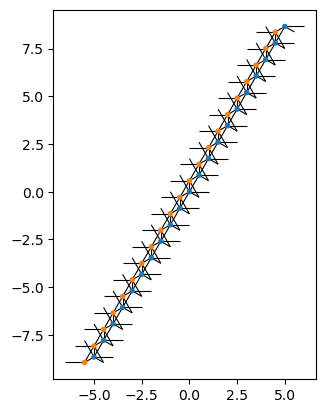

In [488]:
nano_ribbon2 = create_nanoribbon_2(18, 5)
kwant.plot(nano_ribbon2)
plt.show()

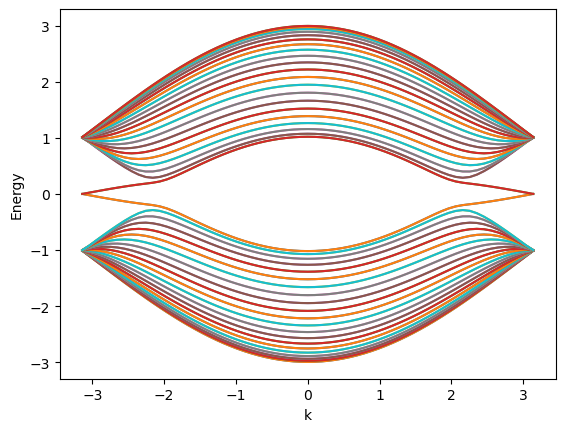

In [489]:
kwant.plotter.bands(nano_ribbon2.finalized(), params=dict(param = SimpleNamespace(B = 0.0, t_prime=0.04, m=0.0)))
plt.show()

# Topological protection